# Hydroelastic Peg In Cuboid
For instructions on how to run these tutorial notebooks, please see the [index](./index.ipynb).

If you are not familiar with Drake's hydroelastic contact, study [hydroelastic_contact_basics.ipynb](./hydroelastic_contact_basics.ipynb). You can also find more information in Hydroelastic Contact User Guide [here.](https://drake.mit.edu/doxygen_cxx/group__hydroelastic__user__guide.html)

## Introduction

This tutorial shows you how to set up simulations using compliant-hydroelastic nonconvex meshes. We'll use a simple example of a bell pepper dropped onto a bowl on a table top, with all three objects represented by compliant-hydroelastic meshes. Contact forces are calculated and visualized.

In [1]:
import os
from pathlib import Path

from IPython.display import Code

from pydrake.geometry import ReadObjToTriangleSurfaceMesh, StartMeshcat
from pydrake.math import RigidTransform
from pydrake.multibody.meshcat import ContactVisualizer, ContactVisualizerParams
from pydrake.multibody.parsing import PackageMap, Parser
from pydrake.multibody.plant import AddMultibodyPlant, MultibodyPlantConfig
from pydrake.multibody.tree import CalcSpatialInertia, SpatialInertia
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.visualization import ApplyVisualizationConfig, ModelVisualizer, VisualizationConfig

## Start MeshCat

See the section [Viewing models](./authoring_multibody_simulation.ipynb#Viewing-models) in the tutorial [Authoring a Multibody Simulation](./authoring_multibody_simulation.ipynb) for an introduction to MeshCat.

In [2]:
# Start the visualizer. The cell will output an HTTP link after the execution.
# Click the link and a MeshCat tab should appear in your browser.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


## Create compliant-hydroelastic bell pepper in SDFormat

*Make sure you have the MeshCat tab opened in your browser; the link is shown immediately above.*

We will load a compliant-hydroelastic bell pepper from an SDFormat file. We will show the file for you to read, and then use `ModelVisualizer` to display it.

The file specifies inertia in the `<inertial>` block. See [mesh_to_model](https://drake.mit.edu/pydrake/pydrake.multibody.mesh_to_model.html) to compute the inertia matrix.

The file specifies visual geometry using a triangle surface mesh and a collision geometry using a tetrahedral volume mesh from a VTK file.

The file's `<drake:proximity_properties>` stanza will control hydroelastic contacts. Look in particular at the `<drake:hydroelastic_modulus>`.

In the MeshCat tab, you should toggle the "proximity" checkbox to show the collision geometry, which is the tetrahedral mesh that fits the visual geometry's triangle mesh.  See the section *Viewing models* in [authoring_multibody_simulation.ipynb](./authoring_multibody_simulation.ipynb) for more details.

In [3]:
# Show the contents of the SDFormat file.
bell_pepper_url = "package://drake_models/veggies/yellow_bell_pepper_no_stem_low.sdf"
bell_pepper_str = Path(PackageMap().ResolveUrl(bell_pepper_url)).read_text(encoding="utf-8")
Code(bell_pepper_str, language="xml")

<?xml version="1.0"?>
<sdf version="1.7" xmlns:drake="drake.mit.edu">
  <model name="yellow_bell_pepper_no_stem">
    <link name="yellow_bell_pepper_no_stem">
      <inertial>
        <pose>0.000537 -0.00272 0.0384 0 0 0</pose>
        <mass>0.159</mass>
        <inertia>
          <ixx> 0.000101</ixx>
          <ixy>-0.000001</ixy>
          <ixz>-0.000004</ixz>
          <iyy> 0.000105</iyy>
          <iyz> 0.000007</iyz>
          <izz> 0.000107</izz>
        </inertia>
      </inertial>
      <visual name="visual">
        <geometry>
          <mesh>
            <uri>package://drake_models/veggies/assets/yellow_bell_pepper_no_stem_low.gltf</uri>
            <scale>1 1 1</scale>
          </mesh>
        </geometry>
      </visual>
      <collision name="collision">
        <geometry>
          <mesh>
            <uri>package://drake_models/veggies/assets/yellow_bell_pepper_no_stem_low.vtk</uri>
            <scale>1 1 1</scale>
          </mesh>
        </geometry>
        <drake:proximity_properties>
          <drake:compliant_hydroelastic/>
          <drake:hydroelastic_modulus>5.0e4</drake:hydroelastic_modulus>
          <!-- Most shapes (capsule, cylinder, ellipsoid, sphere) need
            drake:mesh_resolution_hint, but the resolution hint is no-op
            for the mesh geometry. That's why we do not set it here. -->
          <drake:hunt_crossley_dissipation>10</drake:hunt_crossley_dissipation>
          <!-- Both mu_dynamic and mu_static are used in Continuous system.
            Only mu_dynamic is used in Discrete system.  -->
          <drake:mu_dynamic>0.5</drake:mu_dynamic>
          <drake:mu_static>1.0</drake:mu_static>
        </drake:proximity_properties>
      </collision>
    </link>
    <frame name="origin">
      <pose relative_to="yellow_bell_pepper_no_stem">0 0 0 0 0 0</pose>
    </frame>
    <frame name="flush_bottom_center__z_up">
      <pose relative_to="yellow_bell_pepper_no_stem">0 0 0 0 0 0</pose>
    </frame>
  </model>
</sdf>

## Import Cuboid asset

Hydroelastic contact model needs a collision geometry represented as a tetrahedral mesh in a VTK file. The following document advises how to generate an appropriate tetrahedral mesh from a surface mesh in STL or OBJ.

https://docs.google.com/document/d/1VZtVsxIjOLKvgQ8SNSrF6PtWuPW5z9PP7-dQuxfmqpc/edit?usp=sharing

For visual geometry, Drake prefers an OBJ file. The above document also describes one way to convert STL to OBJ.

In [4]:
# Check the content of the SDF file of the cuboid that will use the mesh in the VTK file.
cuboid_url = "package://drake/tutorials/asset_files/cuboid.sdf"
cuboid_str = Path(PackageMap().ResolveUrl(cuboid_url)).read_text(encoding="utf-8")
Code(cuboid_str, language="xml")

<?xml version="1.0"?>
<sdf version="1.7" xmlns:drake="drake.mit.edu">
  <model name="cuboid">
    <link name="cuboid">
      <inertial>
        <pose>1.9872206908180842e-20 0.0 -0.0018918918918918919 0 0 0</pose>
        <mass>0.8436000000000002</mass>
        <inertia>
          <ixx>0.001498740540540541</ixx> <ixy>-1.1787323728880644e-21</ixy> <ixz>-2.3891807880015855e-21</ixz>
          <iyy>0.001498740540540541</iyy> <iyz>-6.286572655403011e-21</iyz>
          <izz>0.0015549600000000008</izz>
        </inertia>
      </inertial>
      <visual name="visual">
        <geometry>
          <mesh>
            <uri>package://drake/tutorials/asset_files/cuboid.obj</uri>
            <!-- Convert millimeters to meters -->
            <scale>0.001 0.001 0.001</scale>
          </mesh>
        </geometry>
      </visual>
      <collision name="collision">
        <geometry>
          <mesh>
            <uri>package://drake/tutorials/asset_files/cuboid.vtk</uri>
            <!-- Convert millimeters to meters -->
            <scale>0.001 0.001 0.001</scale>
          </mesh>
        </geometry>
        <drake:proximity_properties>
          <drake:compliant_hydroelastic/>
          <!-- Young's modulus of HDPE is about 1 GPa (1e9 Pascals) -->
          <drake:hydroelastic_modulus> 1e9 </drake:hydroelastic_modulus>
          <!-- Most shapes (capsule, cylinder, ellipsoid, sphere) need
            drake:mesh_resolution_hint, but the resolution hint is no-op
            for the mesh geometry. That's why we do not set it here. -->
          <drake:hunt_crossley_dissipation>100</drake:hunt_crossley_dissipation>
          <!-- Both mu_dynamic and mu_static are used in Continuous system.
            Only mu_dynamic is used in Discrete system.  -->
          <drake:mu_dynamic>0.75</drake:mu_dynamic>
          <drake:mu_static>1.0</drake:mu_static>
        </drake:proximity_properties>
      </collision>
    </link>
    <frame name="origin">
      <pose relative_to="cuboid">0 0 0 0 0 0</pose>
    </frame>
    <frame name="flush_bottom_center__z_up">
      <pose relative_to="cuboid">0 0 0 0 0 0</pose>
    </frame>
  </model>
</sdf>

In [5]:
# Visualize the SDFormat file you just defined.
visualizer = ModelVisualizer(meshcat=meshcat)
visualizer.AddModels(url=cuboid_url)
visualizer.Run(loop_once=True)

### Verify intertia tensor of the non-convex cuboid

A common problem is the incorrect inertia tensor specified in the description file, which contaminates the solution of the governing equations.

The code below will calculate the inertia matrix from the mesh.  It is a simplified and customized version from this [snippet](https://github.com/DamrongGuoy/drake/blob/3117d1787a694e91c4723b14d445b1079be799e9/bindings/pydrake/multibody/_mesh_model_maker.py#L152-L245) in bindings/pydrake/multibody/_mesh_model_maker.py.

In [6]:
# The OBJ file uses millimeters. Convert to meters.
mesh_scale = 0.001

cuboid_obj_path = os.path.abspath("/home/damrongguoy/GitHub/DamrongGuoy/drake/tutorials/asset_files/cuboid.obj");
cuboid_surface_mesh = ReadObjToTriangleSurfaceMesh(filename = cuboid_obj_path, scale = mesh_scale)

# Now we use frame notation.  G = the expressed-in frame of the cuboid.
mesh_G = cuboid_surface_mesh
p_GoMin, p_GoMax = mesh_G.CalcBoundingBox()
size = p_GoMax - p_GoMin

print(f"Size of bounding box (we have scaled millimeters to meters): {size[0]} x {size[1]} x {size[2]} meters")

# Uniform mass density of water is 1 kg/m^3.
# The density of iron is 7800 kg/m^3.
# The density of HDPE (High-Density Polyethylene) plastic is about 950 kg/m^3.
# The density of PVC (Polyvinyl Chloride) is about 1400 kg/m^3.
#
# If we change the mass density here, please also change the
# corresponding <drake:hydroelastic_modulus> with the new Young's modulus.
# For example, Young's modulus of iron is about 200 GPa (2e11 Pascals).
# Young's modulus of HDPE is about 1 GPa (1e9 Pascals).
# Young's modulus of rigid PVC is about 3.7 GPa (3.7e9 Pascals).
mass_density = 950
print(f"Uniform mass density: {mass_density} kg/m^3 (reference, water has mass density 1.0 kg/m^3)")

M_GGo_G = CalcSpatialInertia(mesh = mesh_G, density = mass_density)
volume = M_GGo_G.get_mass() / mass_density
print(f"Volume: {volume} cubic meters (less than 0.1^3 = 0.001 m^3 due to the cavity)")

p_GoGcm = M_GGo_G.get_com()
print(f"Center of mass (p_GoGcm): [{p_GoGcm[0]}, {p_GoGcm[1]}, {p_GoGcm[2]}], \n"
       "    which locates at about (0,0,-0.002) meters slightly down from the frame's origin due to the cavity.")

M_GGcm_G = M_GGo_G.Shift(p_GoGcm)
mass = M_GGo_G.get_mass()
print(f"Mass: {mass} kg, less than bounding-box volume times mass density due to the cavity.")

I_GGcm_G = M_GGcm_G.CalcRotationalInertia()
moments = I_GGcm_G.get_moments()
products = I_GGcm_G.get_products()

subs = dict()
# With zero rotation, this is simply the position of com in B.
p_GoGcm_str = " ".join([str(x) for x in p_GoGcm])
subs["inertial_pose"] = f"{p_GoGcm_str} 0 0 0"
subs["mass"] = mass
subs["ixx"] = moments[0]
subs["iyy"] = moments[1]
subs["izz"] = moments[2]
subs["ixy"] = products[0]
subs["ixz"] = products[1]
subs["iyz"] = products[2]
subs["mesh_scale"] = "{s} {s} {s}".format(s = mesh_scale)

_SDF_TEMPLATE = """
      <inertial>
        <pose>{inertial_pose}</pose>
        <mass>{mass}</mass>
        <inertia>
          <ixx>{ixx}</ixx> <ixy>{ixy}</ixy> <ixz>{ixz}</ixz>
          <iyy>{iyy}</iyy> <iyz>{iyz}</iyz>
          <izz>{izz}</izz>
        </inertia>
      </inertial>
"""

print(_SDF_TEMPLATE.format(**subs))

print("Don't forget mesh scale: <scale>", subs["mesh_scale"], "</scale>")

Size of bounding box (we have scaled millimeters to meters): 0.1 x 0.1 x 0.1 meters
Uniform mass density: 950 kg/m^3 (reference, water has mass density 1.0 kg/m^3)
Volume: 0.0008880000000000002 cubic meters (less than 0.1^3 = 0.001 m^3 due to the cavity)
Center of mass (p_GoGcm): [1.9872206908180842e-20, 0.0, -0.0018918918918918919], 
    which locates at about (0,0,-0.002) meters slightly down from the frame's origin due to the cavity.
Mass: 0.8436000000000002 kg, less than bounding-box volume times mass density due to the cavity.

      <inertial>
        <pose>1.9872206908180842e-20 0.0 -0.0018918918918918919 0 0 0</pose>
        <mass>0.8436000000000002</mass>
        <inertia>
          <ixx>0.001498740540540541</ixx> <ixy>-1.1787323728880644e-21</ixy> <ixz>-2.3891807880015855e-21</ixz>
          <iyy>0.001498740540540541</iyy> <iyz>-6.286572655403011e-21</iyz>
          <izz>0.0015549600000000008</izz>
        </inertia>
      </inertial>

Don't forget mesh scale: <scale> 0.001 0

## Import the peg asset

In [7]:
# Check the content of the SDF file of the peg that will use the mesh in the VTK file.
peg_url = "package://drake/tutorials/asset_files/peg.sdf"
peg_str = Path(PackageMap().ResolveUrl(peg_url)).read_text(encoding="utf-8")
Code(peg_str, language="xml")

<?xml version="1.0"?>
<sdf version="1.7" xmlns:drake="drake.mit.edu">
  <model name="peg">
    <link name="peg">
      <inertial>
        <pose>3.92144882988102e-19 -3.92144882988102e-19 0.0 0 0 0</pose>
        <mass>0.7020000000000001</mass>
        <inertia>
          <!-- Since the peg is 3:3:10 in x:y:z length, -->
          <!-- its Ixx:Iyy:Izz is about 109:109:18 or 6:6:1 -->
          <!-- Ixx = (1/12) * mass * (L.y^2 + L.z^2) -->
          <ixx>0.0006376499999999998</ixx> <ixy>-1.0795188169613405e-37</ixy> <ixz>0.0</ixz>
          <iyy>0.0006376499999999998</iyy> <iyz>-0.0</iyz>
          <izz>0.00010529999999999998</izz>
        </inertia>
      </inertial>
      <visual name="visual">
        <geometry>
          <mesh>
            <uri>package://drake/tutorials/asset_files/peg.obj</uri>
            <!-- Convert millimeters to meters -->
            <scale>0.001 0.001 0.001</scale>
          </mesh>
        </geometry>
      </visual>
      <collision name="collision">
        <geometry>
          <mesh>
            <uri>package://drake/tutorials/asset_files/peg.vtk</uri>
            <!-- Convert millimeters to meters -->
            <scale>0.001 0.001 0.001</scale>
          </mesh>
        </geometry>
        <drake:proximity_properties>
          <drake:compliant_hydroelastic/>
          <!-- Young's modulus of iron is about 200 GPa -->
          <drake:hydroelastic_modulus> 2e11 </drake:hydroelastic_modulus>
          <drake:hunt_crossley_dissipation>100</drake:hunt_crossley_dissipation>
          <!-- Both mu_dynamic and mu_static are used in Continuous system.
            Only mu_dynamic is used in Discrete system.  -->
          <drake:mu_dynamic>0.75</drake:mu_dynamic>
          <drake:mu_static>0.75</drake:mu_static>
        </drake:proximity_properties>
      </collision>
    </link>
    <frame name="origin">
      <pose relative_to="peg">0 0 0 0 0 0</pose>
    </frame>
    <frame name="flush_bottom_center__z_up">
      <pose relative_to="peg">0 0 0 0 0 0</pose>
    </frame>
  </model>
</sdf>

In [8]:
# Visualize the SDFormat file you just defined.
visualizer = ModelVisualizer(meshcat=meshcat)
visualizer.AddModels(url=peg_url)
visualizer.Run(loop_once=True)

### Verify the inertia tensor of the peg

Since the peg is longest in its Z direction with the ratio about 3:3:10 in x:y:z, their corresponding entries in the inertia tensor Ixx:Iyy:Izz would be about 109:109:18 or about 6:6:1.  See https://en.wikipedia.org/wiki/List_of_moments_of_inertia or this picture.

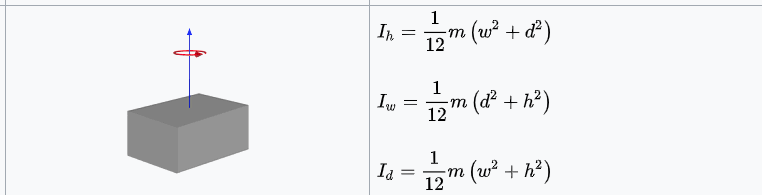

In [9]:
# The OBJ file uses millimeters. Convert to meters.
mesh_scale = 0.001

peg_obj_path = os.path.abspath("/home/damrongguoy/GitHub/DamrongGuoy/drake/tutorials/asset_files/peg.obj");
peg_surface_mesh = ReadObjToTriangleSurfaceMesh(filename = peg_obj_path, scale = mesh_scale)

# Now we use frame notation.  G = the expressed-in frame of the peg.
mesh_G = peg_surface_mesh
p_GoMin, p_GoMax = mesh_G.CalcBoundingBox()
size = p_GoMax - p_GoMin

print(f"Size of bounding box (we have scaled millimeters to meters): {size[0]} x {size[1]} x {size[2]} meters")

# Uniform mass density of water is 1 kg/m^3.
# The density of iron is 7800 kg/m^3.
# The density of HDPE (High-Density Polyethylene) plastic is about 950 kg/m^3.
# The density of PVC (Polyvinyl Chloride) is about 1400 kg/m^3.
#
# If we change the mass density here, please also change the
# corresponding <drake:hydroelastic_modulus> with the new Young's modulus.
# For example, Young's modulus of iron is about 200 GPa (2e11 Pascals).
# Young's modulus of HDPE is about 1 GPa (1e9 Pascals).
# Young's modulus of rigid PVC is about 3.7 GPa (3.7e9 Pascals).
mass_density = 7800
print(f"Uniform mass density: {mass_density} kg/m^3 (reference, water has mass density 1.0 kg/m^3)")

M_GGo_G = CalcSpatialInertia(mesh = mesh_G, density = mass_density)
volume = M_GGo_G.get_mass() / mass_density
print(f"Volume: {volume} cubic meters")

p_GoGcm = M_GGo_G.get_com()
print(f"Center of mass (p_GoGcm): [{p_GoGcm[0]}, {p_GoGcm[1]}, {p_GoGcm[2]}], \n"
       "    which locates at the center of the peg.")

M_GGcm_G = M_GGo_G.Shift(p_GoGcm)
mass = M_GGo_G.get_mass()
print(f"Mass: {mass} kg")

I_GGcm_G = M_GGcm_G.CalcRotationalInertia()
moments = I_GGcm_G.get_moments()
products = I_GGcm_G.get_products()

subs = dict()
# With zero rotation, this is simply the position of com in B.
p_GoGcm_str = " ".join([str(x) for x in p_GoGcm])
subs["inertial_pose"] = f"{p_GoGcm_str} 0 0 0"
subs["mass"] = mass
subs["ixx"] = moments[0]
subs["iyy"] = moments[1]
subs["izz"] = moments[2]
subs["ixy"] = products[0]
subs["ixz"] = products[1]
subs["iyz"] = products[2]
subs["mesh_scale"] = "{s} {s} {s}".format(s = mesh_scale)

_SDF_TEMPLATE = """
      <inertial>
        <pose>{inertial_pose}</pose>
        <mass>{mass}</mass>
        <inertia>
          <!-- Since the peg is 3:3:10 in x:y:z length, -->
          <!-- its Ixx:Iyy:Izz is about 109:109:18 or 6:6:1 -->
          <!-- Ixx = (1/12) * mass * (L.y^2 + L.z^2) -->
          <ixx>{ixx}</ixx> <ixy>{ixy}</ixy> <ixz>{ixz}</ixz>
          <iyy>{iyy}</iyy> <iyz>{iyz}</iyz>
          <izz>{izz}</izz>
        </inertia>
      </inertial>
"""

print(_SDF_TEMPLATE.format(**subs))

print("Don't forget mesh scale: <scale>", subs["mesh_scale"], "</scale>")

Size of bounding box (we have scaled millimeters to meters): 0.03 x 0.03 x 0.1 meters
Uniform mass density: 7800 kg/m^3 (reference, water has mass density 1.0 kg/m^3)
Volume: 9e-05 cubic meters
Center of mass (p_GoGcm): [3.92144882988102e-19, -3.92144882988102e-19, 0.0], 
    which locates at the center of the peg.
Mass: 0.7020000000000001 kg

      <inertial>
        <pose>3.92144882988102e-19 -3.92144882988102e-19 0.0 0 0 0</pose>
        <mass>0.7020000000000001</mass>
        <inertia>
          <!-- Since the peg is 3:3:10 in x:y:z length, -->
          <!-- its Ixx:Iyy:Izz is about 109:109:18 or 6:6:1 -->
          <!-- Ixx = (1/12) * mass * (L.y^2 + L.z^2) -->
          <ixx>0.0006376499999999998</ixx> <ixy>-1.0795188169613405e-37</ixy> <ixz>0.0</ixz>
          <iyy>0.0006376499999999998</iyy> <iyz>-0.0</iyz>
          <izz>0.00010529999999999998</izz>
        </inertia>
      </inertial>

Don't forget mesh scale: <scale> 0.001 0.001 0.001 </scale>


## Create compliant-hydroelastic bowl in URDF

We will load a compliant-hydroelastic bowl with URDF file. We will show the file for you to read, and then use `ModelVisualizer` to display it.

The file specifies inertia in the `<inertial>` block. See [mesh_to_model](https://drake.mit.edu/pydrake/pydrake.multibody.mesh_to_model.html) to compute the inertia matrix.

The file specifies visual geometry using a triangle surface mesh and a collision geometry using a tetrahedral volume mesh from a VTK file.

In the `<drake:proximity_properties>` block, the `<drake:hydroelastic_modulus>` is set to 1e7 Pascals, so the bowl is stiffer than the bell pepper.

In [10]:
# Show the contents of the URDF file.
bowl_url = "package://drake_models/dishes/evo_bowl_compliant.urdf"
bowl_str = Path(PackageMap().ResolveUrl(bowl_url)).read_text(encoding="utf-8")
Code(bowl_str, language="xml")

<?xml version="1.0"?>
<robot xmlns:drake="http://drake.mit.edu" name="bowl">
  <link name="bowl">
    <inertial>
      <mass value="0.5"/>
      <origin xyz="-6.8577139059790044e-06 -1.7473168538940867e-05 -0.003065665933405878"/>
      <inertia ixx="0.0009715521141455593"
               ixy="-1.8443983471817828e-07"
               ixz="2.4082416205698527e-08"
               iyy="0.0009793965751030533"
               iyz="6.72877272895659e-08"
               izz="0.001592061359500251"/>
    </inertial>
    <visual name="visual">
      <geometry>
        <mesh filename="package://drake_models/dishes/assets/evo_bowl.gltf"/>
      </geometry>
    </visual>
    <collision name="collision">
      <geometry>
        <mesh filename="package://drake_models/dishes/assets/evo_bowl_fine44k.vtk"/>
      </geometry>
      <drake:proximity_properties>
        <drake:compliant_hydroelastic/>
        <drake:hydroelastic_modulus value="1e7"/>
        <drake:mu_dynamic value="0.5"/>
        <drake:hunt_crossley_dissipation value="1.25"/>
      </drake:proximity_properties>
    </collision>
  </link>
</robot>

In [11]:
# During development, we use a coarser tetrahedral mesh to improve debug performance.
test_mode = True
if test_mode:
    bowl_str = bowl_str.replace("evo_bowl_fine44k.vtk", 
                                "evo_bowl_coarse3k.vtk")

## Create compliant-hydroelastic table top in URDF

The following URDF file specifies a compliant-hydroelastic box for a table top.  We demonstrate how to set relevant hydroelastic properties in URDF; however, Drake prefers SDFormat to URDF.

Both the `<visual>` and `<collision>` geometries are boxes of the same size.

In the `<drake:proximity_properties>` block, we will set `<drake:hydroelastic_modulus>` to 1e7 Pascals.

We do not specify the inertia matrix of the table top because, in the next section when we set up `Diagram`, we will fix the table top to the world frame. It will not move.

In [12]:
# Show the contents of the URDF file.
table_top_url = "package://drake_models/dishes/table_top.urdf"
table_top_str = Path(PackageMap().ResolveUrl(table_top_url)).read_text(encoding="utf-8")
Code(table_top_str, language="xml")

<?xml version="1.0"?>
<robot name="table_top" xmlns:drake="http://drake.mit.edu">
  <link name="table_top_link">
    <inertial>
      <inertia ixx="2.5062" ixy="0" ixz="0" iyy="0.90625" iyz="0" izz="3.4"/>
      <mass value="30"/>
      <origin rpy="0 0 0" xyz="0 0 0"/>
    </inertial>
    <visual name="visual">
      <geometry>
        <box size="0.6 1.0 0.05"/>
      </geometry>
      <material>
       <color rgba="0.9 0.8 0.7 0.5"/>
      </material>
    </visual>
    <collision name="collision">
      <geometry>
        <box size="0.6 1.0 0.05"/>
      </geometry>
      <drake:proximity_properties>
        <drake:compliant_hydroelastic/>
        <drake:hydroelastic_modulus value="1e7"/>
        <drake:mu_dynamic value="0.5"/>
        <drake:hunt_crossley_dissipation value="1.25"/>
      </drake:proximity_properties>
    </collision>
  </link>
  <frame name="top_surface" link="table_top_link" xyz="0 0 0.025" rpy="0 0 0"/>
</robot>

## Create Diagram of the scene

The function `add_scene()` below will create a scene using the assets that we created. It will use `Parser` to add the URDF and SDFormat strings into the scene. After this step, the next section will add visualization.

In [13]:
def add_scene(time_step):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlant(
        MultibodyPlantConfig(
            time_step=time_step,
            #discrete_contact_approximation="lagged"
        ),
        builder)
    parser = Parser(builder)

    # Load the assets that we created.
    parser.AddModels(url=bell_pepper_url)
    parser.AddModels(file_contents=bowl_str, file_type="urdf")
    parser.AddModels(url=peg_url)
    parser.AddModels(url=cuboid_url)
    parser.AddModels(url=table_top_url)

    # Weld the table top to the world so that it's fixed during simulation.
    # The top surface passes the world's origin.
    plant.WeldFrames(plant.world_frame(), 
                     plant.GetFrameByName("top_surface"))

    # Finalize the plant after loading the scene.
    plant.Finalize()

    # Place the bowl on top of the table.
    X_WB = RigidTransform(p=[0.12, 0.12, 0.03])
    plant.SetDefaultFreeBodyPose(plant.GetBodyByName("bowl"), X_WB)
    
    
    # Place the peg above the cuboid.
    # The peg is about 3x3x10 centimeters.
    # Place its center at +20cm in Z, so it has 5 centimeters to go
    # before contacting the cuboid.
    X_WPeg = RigidTransform(p=[0.015, 0.015, 0.20])
    plant.SetDefaultFreeBodyPose(plant.GetBodyByName("peg"), X_WPeg)
    
    
    # Place the cuboid at the center of the table.
    # The cuboid is about 10 centimeter long, so its pose is +10cm in Z.
    X_WCuboid = RigidTransform(p=[0, 0, 0.05])
    plant.SetDefaultFreeBodyPose(plant.GetBodyByName("cuboid"), X_WCuboid)
    
    # Drop the bell pepper.
    X_WC = RigidTransform(p=[-0.06, 0, 0.20])
    plant.SetDefaultFreeBodyPose(plant.GetBodyByName("yellow_bell_pepper_no_stem"), X_WC)

    return builder, plant

## Set up visualization

The function `add_viz()` below will create visualization. First we will call `ApplyVisualizationConfig()` to visualize our assets. At this step we will set `publish_contacts=False`, so we can customize contact visualization afterwards. 

To visualize contact result, we will add `ContactVisualizer` with `newtons_per_meter= 20` and `newtons_meters_per_meter= 0.1`. It will draw a red arrow of length 1 meter for each force of 20 newtons and a blue arrow of length 1 meter for each torque of 0.1 newton\*meters. The next section will run the simulation.

In [14]:
def add_viz(builder, plant):
    ApplyVisualizationConfig(
        builder=builder, meshcat=meshcat,
        config=VisualizationConfig(
                 publish_contacts=False))    
    ContactVisualizer.AddToBuilder(
        builder=builder, plant=plant, meshcat=meshcat,
        params=ContactVisualizerParams(
                 newtons_per_meter=20,
                 newton_meters_per_meter= 0.1))

## Run simulation

We will run the simulation. In MeshCat, the red arrow will represent the force `f`, and the blue arrow will represent the torque `tau`. You should see the contact patch moving around together with the force and torque vectors.

After running the code below, playback with `timeScale` = 0.1 to appreciate the contact dynamics. You should see the force and torque vectors oscillate synchronously with the rocking bell pepper and bowl. See the section *Playback recording of the simulation* in [hydroelastic_contact_basics.ipynb](./hydroelastic_contact_basics.ipynb) for more details.

Currently playing back the simulation will show contact force and torque correctly; however, it does not show contact patch appropriately, which could be confusing. Issue [19142](https://github.com/RobotLocomotion/drake/issues/19142) explains the problem in more details.

In [15]:
# Clear MeshCat window from the previous blocks.
meshcat.Delete()
meshcat.DeleteAddedControls()

time_step = 1e-2
builder, plant = add_scene(time_step)
add_viz(builder, plant)

diagram = builder.Build()

simulator = Simulator(diagram)

sim_time = 3

meshcat.StartRecording()
simulator.set_target_realtime_rate(1)
simulator.AdvanceTo(sim_time)
meshcat.StopRecording()
meshcat.PublishRecording()

## Download simulation result into a html file for sharing

You can download the simulation result into a self-contained html file, allowing others to playback the simulated results without simulating. The following code prints the URL for downloading. Click on the printed URL to download.

In [16]:
print(f"{meshcat.web_url()}/download")

http://localhost:7000/download


## Further reading

* [Hydroelastic Contact User Guide](https://drake.mit.edu/doxygen_cxx/group__hydroelastic__user__guide.html)

* Elandt, R., Drumwright, E., Sherman, M., & Ruina, A. (2019, November). A pressure field model for fast, robust approximation of net contact force and moment between nominally rigid objects. In 2019 IEEE/RSJ International Conference on Intelligent Robots and Systems(IROS) (pp. 8238-8245). IEEE. [link](https://arxiv.org/abs/1904.11433)

* Masterjohn, J., Guoy, D., Shepherd, J., & Castro, A. (2022). Velocity Level Approximation of Pressure Field Contact Patches. IEEE Robotics and Automation Letters 7, no. 4 (2022): 11593-11600. [link](https://arxiv.org/abs/2110.04157v2)

* Elandt, R. (2022, December). Pressure Field Contact. Dissertation. Cornell University. [link](https://ecommons.cornell.edu/handle/1813/112919)